# Images only

We wanted to know how informative the images are with regard to this task. For example, if most of the queries  refer to a man in the middle of the image, a model can learn to identify the object just by looking at the image and without processing the textual phrase. Moreover, we wanted to test the ability of the model to overfit the images. For this purpose we've tested SG without considering the queries. That is, given a bboxes, we calculate its probability to be the ground truth bbox by:

\begin{align}
P(bbox) = softmax(relu(<context, Satt+b>))
\end{align}

Where $Satt$ is the bbox embedding, $b$ is some bias and $context$ is a trainable vector. We've also tried to use LN (layer normalization) over the VGG16 and scale its ouputs. The experiments were done with and without the spatial features.


In [1]:
import numpy as np
import tensorflow as tf
import json
from datetime import datetime
import os
import sys
sys.path.append('../')
sys.path.append('../models/')
import retriever
from stats import stats
from tabulate import tabulate
from runImgOnly import RunModel as Model

%matplotlib inline  

In [2]:
trainset_file = '../data/training/train_data.bin'
testset_file = '../data/training/test_data.bin'
vocab_file =  '../data/metadata/w2v_vocab.json'
params_dir_tmp = '../data/training/models/imagesOnly/'

<h3>Each entry in this list has the following structure:</h3>
<ul>
<li>entry[0]: query indexes </li>
<li>entry[1:n]: n items where each item is [bounding box vector, bounding box spaital features]. Note that different enteries might have different number of possible  bounding boxes (i.e. different n) </li>
<li>entry[n+1]: integer, entry[ 1 + entry[n+1]] is the ture bbox </li>
</ul>

In [3]:
trainset = np.load(open(trainset_file, 'rb'))

# delete data points where the query length is zero
trainset = np.array([item for item in trainset if len(item[0])!=0])

testset = np.load(open(testset_file, 'rb'))

# delete data points where the query length is zero
testset = np.array([item for item in testset if len(item[0])!=0])

# loading vocabulary 
with open(vocab_file, 'r') as f:
    vocab = json.loads(f.read())
vocab['<unk>'] = len(vocab)

print("Number of words:", len(vocab))

Number of words: 8242


All the experiments show that the performances on the test set are similar to the RAND model, where we randomly chose one of the candidates bboxes as the ground truth one. However, the graphs show that without scaled LN layer, the best results are indeed the outcome of random noise, but when scaled LN layer is added, the models actually learn. Note that the ability to learn without the textual queries might hurt the model's ability to learn how to use textual information when it's available. Moreover, it seems that adding a scaled LN layer regularizes the model. Finally, it seems that adding spatial information doesn't affect the performances (on both the train and test sets), which implies that the model can not exploit the locations distribution of the referred objects.

# Images + Spatial 

We start by testing SG with the spatial features and without the queries. 

In [13]:
num_hidden = 200

params_dir = params_dir_tmp+'simple'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=num_hidden,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=trainset[0][1][1].shape[1], 
    lr=.05,
    decay_steps=10000, 
    decay_rate=0.9, 
    useCDN=False,
    use_spatial=True,
    params_dir=params_dir,
    vocab=vocab
)

print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
tst, trn = m.train(trainset, testset,
        epochs_num=2,
        start_epoch=0)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')  

Train accuracy:0.276
Test accuracy:0.196
Train P@1:0.367
Test P@1:0.300
Train loss loss:2.631
Test loss loss:2.736


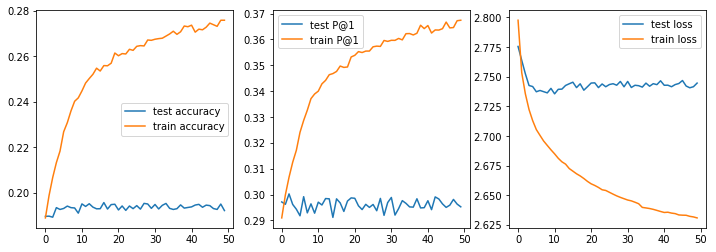

---------------------------------------------------------------------------------------------------- 



In [14]:
f = stats([tst], [trn], epochs=50, params=[200])

# Images + Spatial  + Scaling 

We now add a scaled LN layer (scaled by 0.023) over the VGG16 outputs

In [18]:
num_hidden = 200

params_dir = params_dir_tmp+'scaling'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=num_hidden,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=trainset[0][1][1].shape[1], 
    lr=.05,
    decay_steps=10000, 
    decay_rate=0.9, 
    useCDN=True,
    IMGscale=0.023, 
    use_spatial=True
)

print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
tst, trn = m.train(trainset, testset,
        epochs_num=50,
        start_epoch=0)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')   

Train accuracy:0.228
Test accuracy:0.198
Train P@1:0.320
Test P@1:0.299
Train loss loss:2.702
Test loss loss:2.721


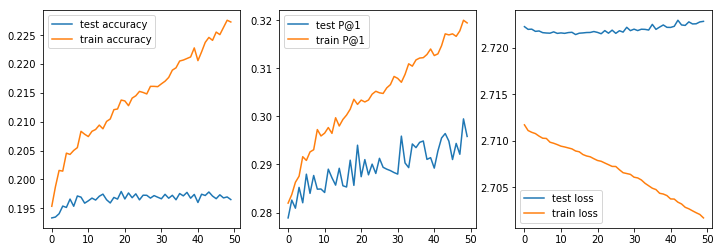

---------------------------------------------------------------------------------------------------- 



In [21]:
f = stats([tst], [trn], epochs=50, params=[200])

# Images 

In this experiment both the textual queries and the spatial information are not used. 

In [22]:
num_hidden = 200

params_dir = params_dir_tmp+'simpleNOspat'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=num_hidden,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=trainset[0][1][1].shape[1], 
    lr=.05,
    decay_steps=10000, 
    decay_rate=0.9, 
    useCDN=False,
    use_spatial=False
)

print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)

tst, trn = m.train(trainset, testset,
        epochs_num=50,
        start_epoch=0)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')  

Train accuracy:0.274
Test accuracy:0.195
Train P@1:0.367
Test P@1:0.302
Train loss loss:2.630
Test loss loss:2.734


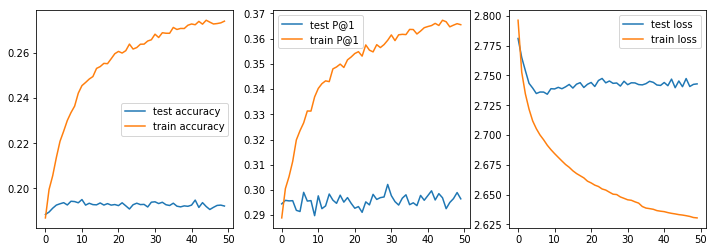

---------------------------------------------------------------------------------------------------- 



In [24]:
f = stats([tst], [trn], epochs=50, params=[200])

# Images + Scaling

Again, we add a scaled LN layer (scaled by 0.023) over the VGG16 outputs (without the textual and the spatial information)

In [25]:
num_hidden = 200

params_dir = params_dir_tmp+'scalingNOspat'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=num_hidden,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=trainset[0][1][1].shape[1], 
    lr=.05,
    decay_steps=10000, 
    decay_rate=0.9, 
    useCDN=True,
    IMGscale=0.023, 
    use_spatial=False
)

print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)

tst, trn = m.train(trainset, testset,
        epochs_num=50,
        start_epoch=0)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n') 

Train accuracy:0.227
Test accuracy:0.197
Train P@1:0.322
Test P@1:0.295
Train loss loss:2.702
Test loss loss:2.722


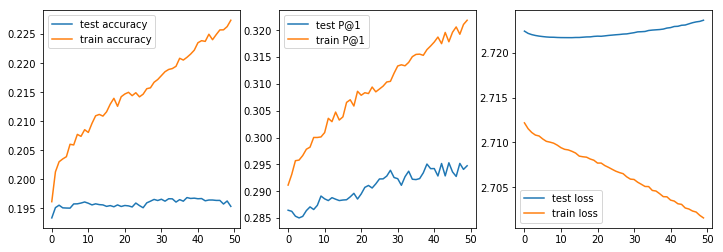

---------------------------------------------------------------------------------------------------- 



In [28]:
f = stats([tst], [trn], epochs=50, params=[200])